In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [10]:
train = pd.read_csv('/Users/baptistenauguier/Desktop/PosterM2/Concours Kaggle/Surpoids_Multiclasse/train.csv')
test = pd.read_csv('/Users/baptistenauguier/Desktop/PosterM2/Concours Kaggle/Surpoids_Multiclasse/test.csv')
test.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


# Correlation

In [11]:
train['Gender'] = train['Gender'].replace({'Male' : 0, 'Female' : 1})
train['family_history_with_overweight'] = train['family_history_with_overweight'].replace({'yes' : 1, 'no' : 0})
train['FAVC'] = train['FAVC'].replace({'yes' : 1, 'no' : 0})
train['SMOKE'] = train['SMOKE'].replace({'yes' : 1, 'no' : 0})
train['SCC'] = train['SCC'].replace({'yes' : 1, 'no' : 0})
train['CAEC'] = train['CAEC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
train['CALC'] = train['CALC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
train['NObeyesdad'] = train['NObeyesdad'].replace({'Insufficient_Weight' : 0, 'Normal_Weight' : 1, 'Overweight_Level_I' : 2, 'Overweight_Level_II' : 3, 'Obesity_Type_I' : 4, 'Obesity_Type_II' : 5, 'Obesity_Type_III' : 6})
train['MTRANS'] = train['MTRANS'].replace({'Public_Transportation' : 0, 'Automobile' : 1, 'Motorbike' : 2, 'Bike' : 3, 'Walking' : 4})

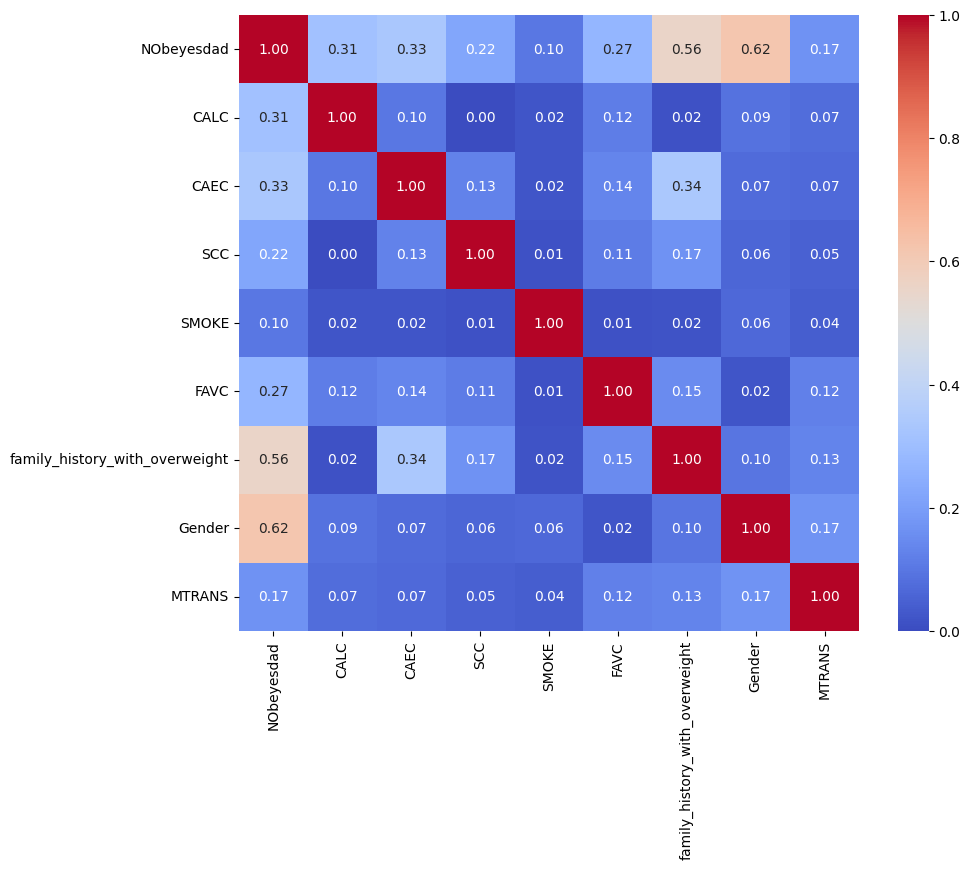

In [12]:
import numpy as np
from scipy.stats import chi2_contingency

# nous utilisons le V de cramer car nos observations sont ici qualitative et indépendante et nous avons une matrice
# carré 

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


cols = ['NObeyesdad','CALC','CAEC','SCC','SMOKE','FAVC','family_history_with_overweight','Gender', 'MTRANS']
cramers_v_matrix = pd.DataFrame(index=cols, columns=cols)

for col1 in cols:
    for col2 in cols:
        cramers_v_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

import seaborn as sns
import matplotlib.pyplot as plt

cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

# les coefficient avec 2 fois la même variable ne sont pas à 1 car nous avons une correction de la continuité pour
# faire face au sous effectif dans certaines cases de la matrice de contingence

# Random forest multiclass

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Séparer les caractéristiques et la variable cible
X = train.iloc[:, :-1]  # toutes les colonnes sauf la dernière
y = train.iloc[:, -1]   # la dernière colonne

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle de forêt aléatoire
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=13)

# Entraîner le modèle
rf.fit(X_train, y_train)

# Évaluer le modèle
predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.95      0.92      0.93       524
           1       0.84      0.89      0.87       626
           2       0.78      0.75      0.77       484
           3       0.79      0.81      0.80       514
           4       0.89      0.87      0.88       543
           5       0.97      0.97      0.97       657
           6       1.00      1.00      1.00       804

    accuracy                           0.90      4152
   macro avg       0.89      0.89      0.89      4152
weighted avg       0.90      0.90      0.90      4152



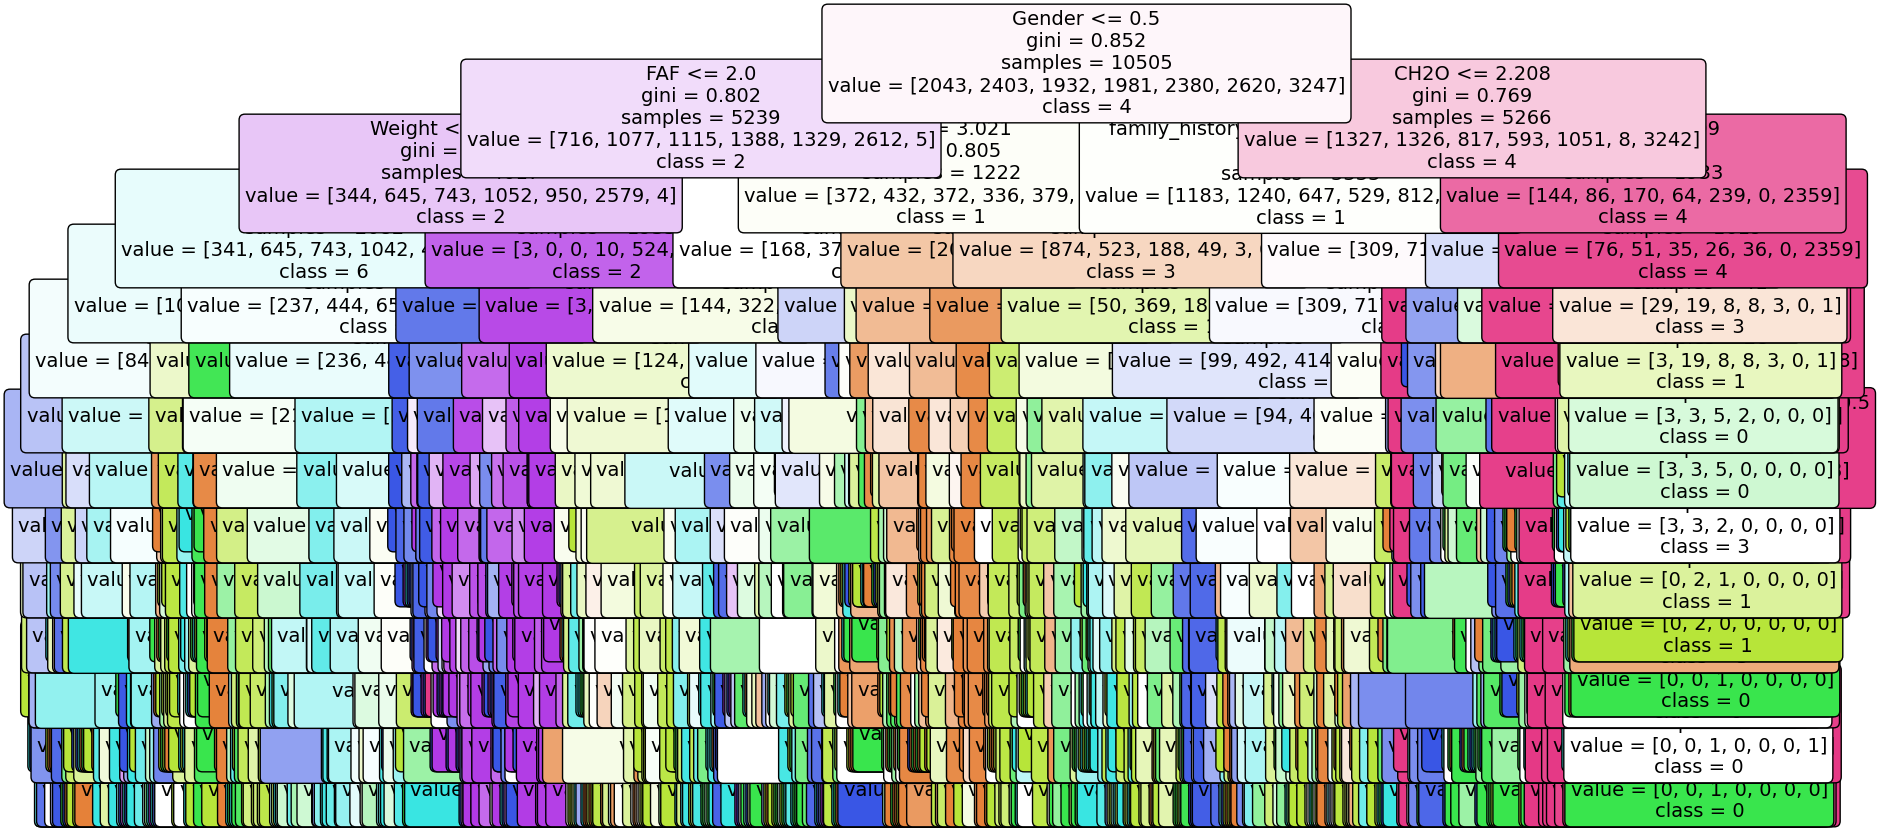

In [32]:
# Affichage Arbre 

from sklearn import tree
import matplotlib.pyplot as plt

# Sélectionnez un arbre spécifique
estimator = rf.estimators_[5]

plt.figure(figsize=(20,10))
class_names = [str(i) for i in y.unique()]

tree.plot_tree(estimator, 
               feature_names=X.columns, 
               class_names=class_names, 
               filled=True, 
               rounded=True, 
               fontsize=14)
plt.show()

In [15]:
test['Gender'] = test['Gender'].replace({'Male' : 0, 'Female' : 1})
test['family_history_with_overweight'] = test['family_history_with_overweight'].replace({'yes' : 1, 'no' : 0})
test['FAVC'] = test['FAVC'].replace({'yes' : 1, 'no' : 0})
test['SMOKE'] = test['SMOKE'].replace({'yes' : 1, 'no' : 0})
test['SCC'] = test['SCC'].replace({'yes' : 1, 'no' : 0})
test['CAEC'] = test['CAEC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
test['CALC'] = test['CALC'].replace({'no' : 0, 'Sometimes' : 1, 'Frequently' : 2, 'Always' : 3})
test['MTRANS'] = test['MTRANS'].replace({'Public_Transportation' : 0, 'Automobile' : 1, 'Motorbike' : 2, 'Bike' : 3, 'Walking' : 4})

In [16]:
predictions2 = rf.predict(test)

In [17]:
predictions2

array([5, 2, 6, ..., 0, 1, 5])

In [18]:
# Réinitialiser l'index de l'ensemble de test pour correspondre aux prédictions
X_test_reset = test.reset_index(drop=True)

# Convertir les prédictions en une série pandas et l'ajouter au DataFrame de test réinitialisé
X_test_reset['predictions'] = pd.Series(predictions2)

# Si nécessaire, vous pouvez maintenant rejoindre cette nouvelle DataFrame avec le DataFrame d'origine
# Pour ce faire, nous devons d'abord réinitialiser l'index du DataFrame d'origine avant la division
df_original_reset = test.reset_index(drop=True)

# Joindre les deux DataFrames sur l'index
df_with_predictions = df_original_reset.join(X_test_reset['predictions'], how='right')


In [19]:
df_with_predictions

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,predictions
0,20758,0,26.899886,1.848294,120.644178,1,1,2.938616,3.000000,1,0,2.825629,0,0.855400,0.000000,1,0,5
1,20759,1,21.000000,1.600000,66.000000,1,1,2.000000,1.000000,1,0,3.000000,0,1.000000,0.000000,1,0,2
2,20760,1,26.000000,1.643355,111.600553,1,1,3.000000,3.000000,1,0,2.621877,0,0.000000,0.250502,1,0,6
3,20761,0,20.979254,1.553127,103.669116,1,1,2.000000,2.977909,1,0,2.786417,0,0.094851,0.000000,1,0,4
4,20762,1,26.000000,1.627396,104.835346,1,1,3.000000,3.000000,1,0,2.653531,0,0.000000,0.741069,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13835,34593,0,23.327836,1.721384,78.030383,1,0,2.813234,3.000000,1,0,1.000000,0,0.807076,0.778632,1,0,3
13836,34594,1,29.000000,1.590000,62.000000,0,1,3.000000,3.000000,1,0,2.000000,0,0.000000,0.000000,1,0,2
13837,34595,1,22.935612,1.585547,44.376637,0,1,3.000000,2.273740,2,0,2.000000,0,1.949840,1.000000,1,0,0
13838,34596,0,21.000000,1.620000,53.000000,1,1,2.000000,3.000000,1,0,2.000000,0,3.000000,2.000000,0,0,1


In [20]:
df_with_predictions['predictions'] = df_with_predictions['predictions'].replace({0 : 'Insufficient_Weight', 1 : 'Normal_Weight', 2 : 'Overweight_Level_I', 3 : 'Overweight_Level_II', 4 : 'Obesity_Type_I', 5 : 'Obesity_Type_II', 6 : 'Obesity_Type_III'})

In [21]:
dfVrai = df_with_predictions[['id', 'predictions']]
dfVrai = dfVrai.rename(columns={'predictions': 'NObeyesdad'})

In [22]:
dfVrai

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Overweight_Level_I
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


In [23]:
#pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [24]:
dfVrai.to_csv('output.csv', index=False)